In the paper, we trained a neural network model, where the input of the model is a star's BP-RP color and its absolute G-band magnitude and the output is the mass of the star. **In this demo, you can train your own model to measure the mass across the entire Hertzsprung-Russell Diagram.**


You can use Google Colab to run this Jupyter notebook (e.g. put this juputer notebook in your Google Drive and open it). Google Colab provides free (at least at the time of writing) GPU that is sufficient for our purposes. You can also run the notebook on your laptop, but GPU may not be available depending on your system. Our codes are mainly developed and tested on the Google Colab environment (with GPU). The free Colab GPU is T4 (at the time of writing), which is sufficient for most of the work here. You can get access to a more powerful GPU if you have a Colab subscription.

If your are using Google Colab (like me), first activate your GPU ("Runtime"->"Change runtime type"). Then we mount the Google Drive (i.e. let this code to get access to the files in your Google Drive). You will get a pop-up window asking you about the permission. Answer "Allow" (if you would like to continue).

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


After mounting, we change the directory ("%cd ...") to our working directory. You may want to change the path name below for your case.

In [2]:
%cd drive/My\ Drive/colab/2022_5_mass_across_HR_diagram/3_reanalysis/26_Github\ files

/content/drive/My Drive/colab/2022_5_mass_across_HR_diagram/3_reanalysis/26_Github files


Now import PyTorch, a Python library for machine learning.

In [3]:
import torch
from torch import nn

print(torch.__version__)

2.0.1+cu118


Then, import the "binary_training_v1" module we developed. This module includes all the detail (e.g. likelihood model, ...) to train the neural network.

In [4]:
import binary_training_v1

import importlib
importlib.reload(binary_training_v1)

from binary_training_v1 import *

v72
v72


We first read the wide binary catalog ([El-Badry+21](https://ui.adsabs.harvard.edu/abs/2021MNRAS.506.2269E/abstract). Available here: https://zenodo.org/record/4435257 . 1.4 GB) using astropy:

In [5]:
from astropy.table import Table
sample_file_name = 'all_columns_catalog.fits.gz'
wb_table = Table.read(sample_file_name)



Then we need to pre-calculate some values (otherwise cannot be loaded to the BinaryTraining() object)

In [6]:
import numpy as np
wb_table['sep_arcsec'] = wb_table['pairdistance'] * 3600.

wb_table['dpmra'] = wb_table['pmra2'] - wb_table['pmra1']
wb_table['dpmdec'] = wb_table['pmdec2'] - wb_table['pmdec1']
wb_table['dpmradec'] = np.sqrt(wb_table['dpmra']**2 + wb_table['dpmdec']**2)

wb_table['dpm_error'] = 1. / wb_table['dpmradec'] * np.sqrt(
        wb_table['dpmra']**2 * (wb_table['pmra_error1']**2 + wb_table['pmra_error2']**2) +
        wb_table['dpmdec']**2 * (wb_table['pmdec_error1']**2 + wb_table['pmdec_error2']**2)
    )

wb_table['dpm_over_error'] = wb_table['dpmradec'] / wb_table['dpm_error']

Apply the target selection criteria (detailed in the paper) and then initialize a BinaryTraining() object:



In [14]:

s_wb_to_use = (
    (wb_table['phot_bp_mean_flux_over_error1'] > 10.) *
    (wb_table['phot_rp_mean_flux_over_error1'] > 10.) *
    (wb_table['phot_g_mean_flux_over_error1'] > 10.) *
    (wb_table['phot_bp_mean_flux_over_error2'] > 10.) *
    (wb_table['phot_rp_mean_flux_over_error2'] > 10.) *
    (wb_table['phot_g_mean_flux_over_error2'] > 10.) *
    (wb_table['bp_rp1'] < 5.) *
    (wb_table['bp_rp2'] < 5.) *
    (wb_table['R_chance_align'] < 0.01) *
    (wb_table['sep_arcsec'] > 2.) *
    (wb_table['sep_AU'] < 10**3.5) *
    (wb_table['parallax1'] > 2.5) *
    (wb_table['parallax_over_error1'] > 10.) *
    (wb_table['ruwe1'] < 1.4) *
    (wb_table['ruwe2'] < 1.4) *
    (wb_table['phot_bp_rp_excess_factor1'] < 1.8) *
    (wb_table['phot_bp_rp_excess_factor2'] < 1.8) *
    (np.abs(wb_table['b1']) > 10.)
)

print(np.sum(s_wb_to_use))

bt = BinaryTraining(wb_table[s_wb_to_use], 'Gaia')

99680
torch version: 2.0.1+cu118
self.device:  cuda


We can quickly check what the sample looks like:

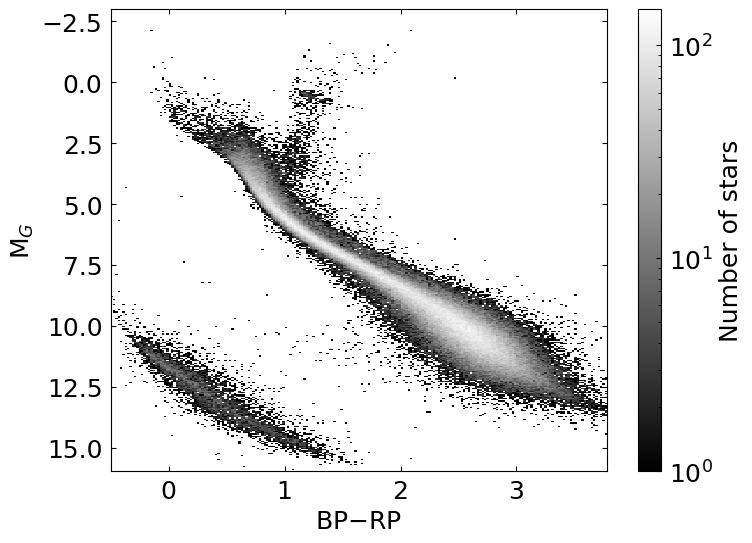

In [8]:
data_x = np.concatenate([bt.wb_table['bp_rp1'], bt.wb_table['bp_rp2']])
data_y = np.concatenate([bt.wb_table['absg1'], bt.wb_table['absg2']])

plt.hist2d(
    data_x,
    data_y,
    bins=[np.arange(-0.5, 3.8, 0.02), np.arange(-3, 16, 0.05)] ,
    norm=LogNorm(),
    cmap='gray'
)
plt.colorbar(label='Number of stars')
plt.gca().invert_yaxis()
plt.xlabel(r'BP$-$RP')
plt.ylabel(r'M$_G$')
plt.show()

Specify that we want 90% of the data for training and 10% for testing (i.e. validation)

In [15]:
bt.sample_preparation(train_data_frac=0.9)

n_train:  89712
n_test:  9968


Set up the training parameters: "num_epochs" is the number of epochs you want. Here we set a smaller number of 100 (we use 500 in the paper, but 100 can already get some decent result). "lr" is the learning rate. "f_outlier" is the outlier fraction, and 0.2 is the number used in the paper. "result_path" is the path you want to save the trained model (which will have a file name "trained_model.pth" ).

In [16]:
bt.init_model_parameters(
    num_epochs = 100,
    lr = 1e-4,
    f_outlier = 0.2,
    result_path='./'
)

Let's start training! Using a T4 GPU, this step can be done in ~2 min.

In [17]:
bt.training()

0
iter 0: training loss = 3.90191 validation loss = 3.89340
1
iter 1: training loss = 3.89158 validation loss = 3.89464
2
iter 2: training loss = 3.89121 validation loss = 3.89313
3
iter 3: training loss = 3.89006 validation loss = 3.89277
4
iter 4: training loss = 3.89025 validation loss = 3.89197
5
iter 5: training loss = 3.88996 validation loss = 3.89238
6
iter 6: training loss = 3.88942 validation loss = 3.89152
7
iter 7: training loss = 3.88874 validation loss = 3.89061
8
iter 8: training loss = 3.88894 validation loss = 3.89080
9
iter 9: training loss = 3.88890 validation loss = 3.88987
10
iter 10: training loss = 3.88849 validation loss = 3.88939
11
iter 11: training loss = 3.88829 validation loss = 3.89055
12
iter 12: training loss = 3.88776 validation loss = 3.88967
13
iter 13: training loss = 3.88791 validation loss = 3.89036
14
iter 14: training loss = 3.88747 validation loss = 3.89035
15
iter 15: training loss = 3.88747 validation loss = 3.89079
16
iter 16: training loss = 

Now derive the mass for the wide binary sample using the trained model. Specifically, we sample the measurement 1000 times to derive the median and the standard deviation. This step takes ~20 sec on T4 GPU.

In [18]:
bt.derive_predict_median_mass_from_sampling()

  0%|          | 0/1000 [00:00<?, ?it/s]

Now let's see what we get!! You should get a quite decent result!

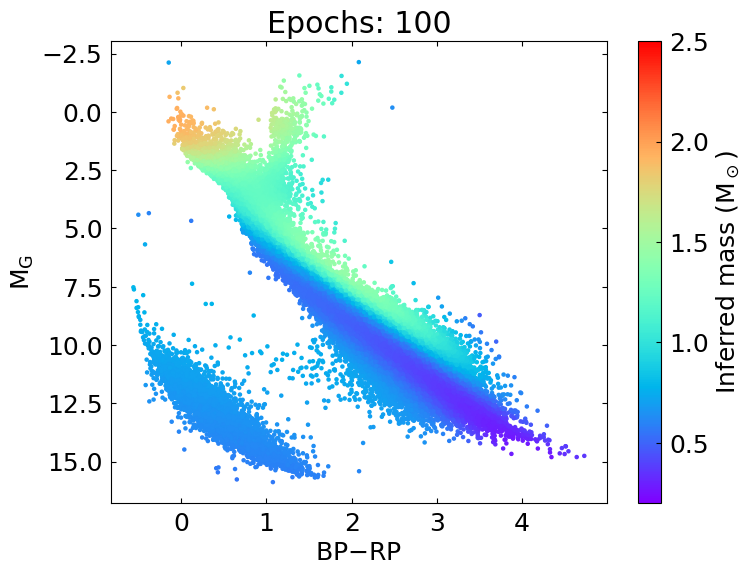

In [19]:
bt.plot_training_result()

plt.title('Epochs: %d' %(bt.num_epochs))
plt.show()